# Prepare

In [1]:

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

import efficientnet
import efficientnet.tfkeras as efn


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2022-05-12 13:40:23.369072: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Functions

In [2]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label-{}.csv'.format(str(int(case_name[-2:]))))
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [3]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [4]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [5]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

# Load Data Set

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-4

all_img_path, all_label = get_train_data('/home/lab05/AI_proj_Team2/AI_proj_Team2/data/train/')
test_img_path = get_test_data('/home/lab05/AI_proj_Team2/AI_proj_Team2/data/test')

In [7]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [8]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

2022-05-12 13:43:44.613835: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-12 13:43:44.614938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-12 13:43:44.681896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 13:43:44.682555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-12 13:43:44.682602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-12 13:43:44.780593: I tensorflow/stream_executor/platform/default/dso_loade

In [9]:
train_dataset

<RepeatDataset shapes: ((8, 256, 256, 3), (8,)), types: (tf.float32, tf.float32)>

In [10]:
valid_dataset

<RepeatDataset shapes: ((8, 256, 256, 3), (8,)), types: (tf.float32, tf.float32)>

# EfficientNetB7 Model

In [11]:
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)
base_model.summary()

258441216/258434480 [==============================] - 20s 0us/step
Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 64) 0           stem_bn[0][0]                    
________________

Total params: 64,097,680
Trainable params: 63,786,960
Non-trainable params: 310,720
__________________________________________________________________________________________________


In [12]:
from tensorflow.keras.regularizers import *

LAMBDA_VAL = 0.001

base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # Flatten??
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(l2=LAMBDA_VAL)))
model.add(Dense(1, activation='linear', kernel_regularizer=L2(l2=LAMBDA_VAL)))

# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   patience=5,
                   verbose=1)

# # Checkpoint
# model_checkpoint = './{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

# checkpointer = ModelCheckpoint(
#     filepath=model_checkpoint,
#     verbose=1,
#     period=2,
#     save_best_weights=True,
#     mode='auto',
#     monitor='val_acc'
# )



In [13]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./pretrained_model.h5')

2022-05-12 13:47:47.883828: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1001127936 exceeds 10% of free system memory.


Epoch 1/30


2022-05-12 13:47:57.682693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-12 13:47:57.793973: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-05-12 13:47:59.986230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-12 13:48:00.656522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


159/159 [==============================] - 41s 164ms/step - loss: 16461.9171 - mae: 79.5837 - val_loss: 10577.3906 - val_mae: 85.1330
Epoch 2/30
159/159 [==============================] - 23s 142ms/step - loss: 10490.0213 - mae: 77.6767 - val_loss: 10777.7363 - val_mae: 83.1735
Epoch 3/30
159/159 [==============================] - 23s 143ms/step - loss: 9355.2263 - mae: 72.2506 - val_loss: 11093.7695 - val_mae: 82.0462
Epoch 4/30
159/159 [==============================] - 23s 144ms/step - loss: 9129.7270 - mae: 70.2449 - val_loss: 11336.3467 - val_mae: 82.4709
Epoch 5/30
159/159 [==============================] - 23s 145ms/step - loss: 9071.3153 - mae: 70.0999 - val_loss: 11290.7822 - val_mae: 81.0342
Epoch 6/30
159/159 [==============================] - 23s 146ms/step - loss: 8719.5180 - mae: 69.0777 - val_loss: 11388.2803 - val_mae: 79.2351
Epoch 7/30
159/159 [==============================] - 23s 147ms/step - loss: 8196.7672 - mae: 66.2978 - val_loss: 11434.2500 - val_mae: 79.2660
E

Text(0.5, 1.0, 'Training and Validation MAE')

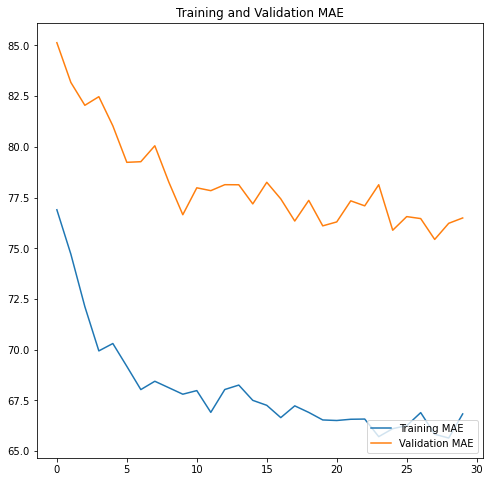

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [15]:
base_model.trainable=False
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [16]:
fine_tune_at= int(len(base_model.layers)*0.9)

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [17]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [18]:
FINE_TUNE_EPOCHS = 30 
history = model.fit(train_dataset, epochs=FINE_TUNE_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model.h5')

2022-05-12 13:59:50.587087: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1001127936 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 37s 166ms/step - loss: 7807.9445 - mae: 66.2537 - val_loss: 10971.2168 - val_mae: 75.6847
Epoch 2/30
159/159 [==============================] - 23s 143ms/step - loss: 7790.0269 - mae: 65.0583 - val_loss: 10973.8682 - val_mae: 75.3220
Epoch 3/30
159/159 [==============================] - 23s 143ms/step - loss: 7788.4198 - mae: 64.8038 - val_loss: 10936.4209 - val_mae: 74.9910
Epoch 4/30
159/159 [==============================] - 23s 143ms/step - loss: 7524.6804 - mae: 63.9426 - val_loss: 10922.8594 - val_mae: 74.7581
Epoch 5/30
159/159 [==============================] - 23s 144ms/step - loss: 7589.8665 - mae: 63.5393 - val_loss: 10927.8135 - val_mae: 74.5087
Epoch 6/30
159/159 [==============================] - 23s 144ms/step - loss: 7599.4926 - mae: 63.3629 - val_loss: 10914.5684 - val_mae: 74.3883
Epoch 7/30
159/159 [==============================] - 23s 144ms/step - loss: 8072.6706 - mae: 65.0690 - val_loss: 10903.8545 - val_mae: 

Text(0.5, 1.0, 'Training and Validation MAE')

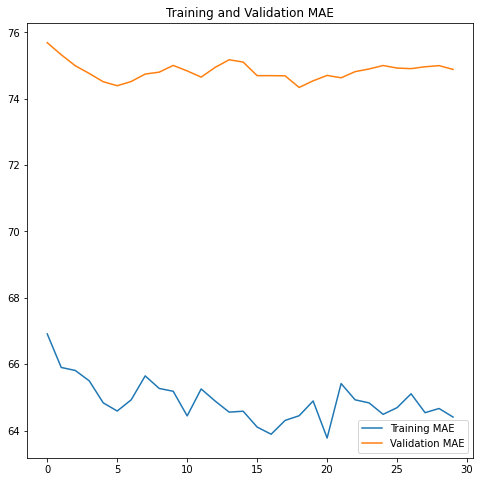

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [20]:
history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model_continue.h5')

2022-05-12 14:12:02.626018: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1001127936 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 23s 146ms/step - loss: 7870.1846 - mae: 64.4565 - val_loss: 10866.8994 - val_mae: 74.9266
Epoch 2/30
159/159 [==============================] - 23s 146ms/step - loss: 7772.8735 - mae: 64.1078 - val_loss: 10866.7910 - val_mae: 74.9506
Epoch 3/30
159/159 [==============================] - 23s 147ms/step - loss: 7867.5039 - mae: 64.5466 - val_loss: 10863.2188 - val_mae: 74.8136
Epoch 4/30
159/159 [==============================] - 23s 147ms/step - loss: 7908.0747 - mae: 64.7038 - val_loss: 10863.1934 - val_mae: 75.0355
Epoch 5/30
159/159 [==============================] - 23s 148ms/step - loss: 7844.8276 - mae: 64.7839 - val_loss: 10877.6846 - val_mae: 75.0760
Epoch 6/30
159/159 [==============================] - 24s 148ms/step - loss: 7782.2539 - mae: 64.2035 - val_loss: 10860.4736 - val_mae: 74.9535
Epoch 7/30
159/159 [==============================] - 23s 147ms/step - loss: 7745.9780 - mae: 64.4725 - val_loss: 10863.0146 - val_mae: 

---
## 규제없는 모델 
&
loss = mae

In [21]:
base_model.trainable = False
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='linear'))

checkpoint_filepath = './no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [22]:
history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

2022-05-12 14:23:59.270367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1001127936 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 37s 165ms/step - loss: 79.9325 - mae: 79.9325 - val_loss: 69.6772 - val_mae: 69.6772

Epoch 00001: val_mae improved from inf to 69.67717, saving model to ./no_regul_pretrain_best_model.h5
Epoch 2/30
159/159 [==============================] - 23s 144ms/step - loss: 71.9283 - mae: 71.9283 - val_loss: 69.0952 - val_mae: 69.0952

Epoch 00002: val_mae improved from 69.67717 to 69.09523, saving model to ./no_regul_pretrain_best_model.h5
Epoch 3/30
159/159 [==============================] - 23s 144ms/step - loss: 70.1818 - mae: 70.1818 - val_loss: 68.4551 - val_mae: 68.4551

Epoch 00003: val_mae improved from 69.09523 to 68.45509, saving model to ./no_regul_pretrain_best_model.h5
Epoch 4/30
159/159 [==============================] - 23s 145ms/step - loss: 68.0255 - mae: 68.0255 - val_loss: 68.0268 - val_mae: 68.0268

Epoch 00004: val_mae improved from 68.45509 to 68.02678, saving model to ./no_regul_pretrain_best_model.h5
Epoch 5/30
159/15

Text(0.5, 1.0, 'Training and Validation MAE')

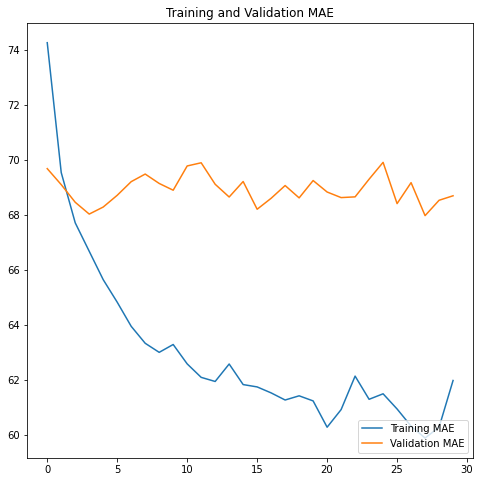

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [24]:
for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [25]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = './no_regul_finetune_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoedl.h5')

Epoch 1/30
159/159 [==============================] - 37s 165ms/step - loss: 60.3100 - mae: 60.3100 - val_loss: 68.4491 - val_mae: 68.4491

Epoch 00001: val_mae improved from inf to 68.44910, saving model to ./no_regul_finetune_best_model.h5
Epoch 2/30
159/159 [==============================] - 23s 144ms/step - loss: 60.3934 - mae: 60.3934 - val_loss: 68.4046 - val_mae: 68.4046

Epoch 00002: val_mae improved from 68.44910 to 68.40457, saving model to ./no_regul_finetune_best_model.h5
Epoch 3/30
159/159 [==============================] - 23s 144ms/step - loss: 60.2245 - mae: 60.2245 - val_loss: 68.4397 - val_mae: 68.4397

Epoch 00003: val_mae did not improve from 68.40457
Epoch 4/30
159/159 [==============================] - 23s 144ms/step - loss: 59.3936 - mae: 59.3936 - val_loss: 68.5078 - val_mae: 68.5078

Epoch 00004: val_mae did not improve from 68.40457
Epoch 5/30
159/159 [==============================] - 23s 144ms/step - loss: 59.0975 - mae: 59.0975 - val_loss: 68.4645 - val_mae

Text(0.5, 1.0, 'Training and Validation MAE')

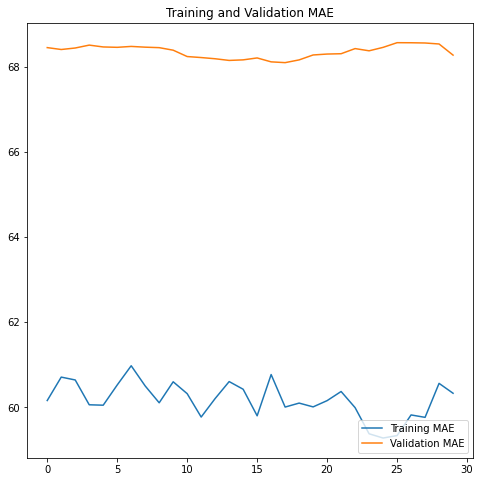

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## learning rate 변경

In [28]:
 base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)

In [29]:

LEARNING_RATE = 1e-4

base_model.trainable = False
model3 = Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) # Flatten??
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='linear'))

checkpoint_filepath = './no_regul_pretrain_best_model_lr.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [30]:
history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)


Epoch 1/30
159/159 [==============================] - 37s 170ms/step - loss: 82.0995 - mae: 82.0995 - val_loss: 73.3717 - val_mae: 73.3717

Epoch 00001: val_mae improved from inf to 73.37173, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 2/30
159/159 [==============================] - 23s 147ms/step - loss: 76.7557 - mae: 76.7557 - val_loss: 70.7185 - val_mae: 70.7185

Epoch 00002: val_mae improved from 73.37173 to 70.71845, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 3/30
159/159 [==============================] - 23s 148ms/step - loss: 74.2500 - mae: 74.2500 - val_loss: 69.9677 - val_mae: 69.9677

Epoch 00003: val_mae improved from 70.71845 to 69.96772, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 4/30
159/159 [==============================] - 23s 147ms/step - loss: 72.8939 - mae: 72.8939 - val_loss: 69.7535 - val_mae: 69.7535

Epoch 00004: val_mae improved from 69.96772 to 69.75355, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch

Text(0.5, 1.0, 'Training and Validation MAE')

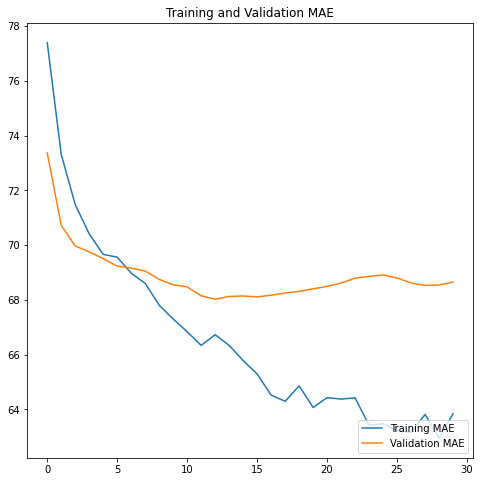

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### finetune

In [32]:
fine_tune_at= int(len(base_model.layers)*0.9)

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [33]:
checkpoint_filepath = './no_regul_pretrain_best_model_lr.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 37s 169ms/step - loss: 63.3531 - mae: 63.3531 - val_loss: 68.6863 - val_mae: 68.6863

Epoch 00001: val_mae improved from inf to 68.68631, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 2/30
159/159 [==============================] - 23s 143ms/step - loss: 62.6067 - mae: 62.6067 - val_loss: 68.6921 - val_mae: 68.6921

Epoch 00002: val_mae did not improve from 68.68631
Epoch 3/30
159/159 [==============================] - 23s 144ms/step - loss: 62.1619 - mae: 62.1619 - val_loss: 68.6978 - val_mae: 68.6978

Epoch 00003: val_mae did not improve from 68.68631
Epoch 4/30
159/159 [==============================] - 23s 144ms/step - loss: 63.1704 - mae: 63.1704 - val_loss: 68.6773 - val_mae: 68.6773

Epoch 00004: val_mae improved from 68.68631 to 68.67727, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 5/30
159/159 [==============================] - 23s 144ms/step - loss: 63.0912 - mae: 63.0912 - val_loss: 68.6702 - v

Text(0.5, 1.0, 'Training and Validation MAE')

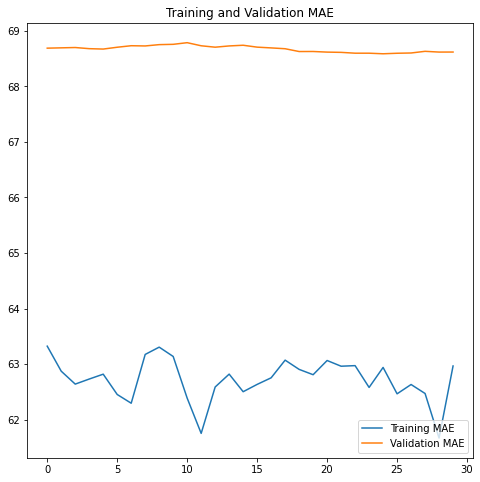

In [34]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# Retry EfficientNet B7 fine tuning add augmentation

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:
IMAGE_SIZE = 256
LEARNING_RATE = 1e-4

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.3)
])

In [ ]:
preprocess_input= tf.keras.applications.efficientnet.preprocess_input
input_data = Input( shape = (None, None ,3) )
x = tf.keras.layers.RandomFlip('horizontal_and_vertical')(input_data)
x = tf.keras.layers.RandomRotation(0.3)(x)
x = preprocess_input(x)
preprocess = Model(inputs=input_data, outputs=x)

In [ ]:
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top = False
)
base_model.trainable = False

In [ ]:
base_model.summary() # train prams => 0

In [ ]:
model = Sequential()
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnet-b4 (Functional  (None, None, None, 1792)  17673816 
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                114752    
                                                                 
 dense_4 (Dense)             (None, 64)               

학습

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/effb4/effb4.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

NameError: ignored

### fine tuen

# Prediction

In [ ]:
len(test_img_path)

460

In [ ]:
PRED_BATCH_SIZE = 10

test set 생성

In [ ]:
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

  0%|          | 0/460 [00:00<?, ?it/s]

model load and predict

In [ ]:
eff_model = tf.keras.models.load_model('/content/drive/MyDrive/AI_proj/no_regul_pretrain_best_model.h5')

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)


In [ ]:
prediction.shape

(460, 1)

In [ ]:
prediction

save to csv

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_proj/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('/content/drive/MyDrive/AI_proj/data/effecientnet_cnn.csv', index=False)

# EfficientNetV2 L Model

In [ ]:
IMAGE_SIZE = 256,
EPOCHS = 30
LEARNING_RATE = 1e-4

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L

In [ ]:
preprocess_input= tf.keras.applications.efficientnet_v2.preprocess_input

In [ ]:
base_model = EfficientNetV2L(include_top = False,
                             weights='imagenet')

In [ ]:
input_data = Input( shape = (None, None ,3) )
x = preprocess_input(input_data)
preprocess = Model(inputs=input_data, outputs=x)

In [ ]:
model = Sequential()
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
base_model.trainable = False

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 79.0538 - mae: 79.0538
Epoch 1: val_mae improved from inf to 64.20319, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 53s 236ms/step - loss: 79.0538 - mae: 79.0538 - val_loss: 64.2032 - val_mae: 64.2032
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 76.9916 - mae: 76.9916
Epoch 2: val_mae improved from 64.20319 to 61.93242, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 33s 205ms/step - loss: 76.9916 - mae: 76.9916 - val_loss: 61.9324 - val_mae: 61.9324
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 75.6076 - mae: 75.6076
Epoch 3: val_mae improved from 61.93242 to 60.24652, saving model to /content/drive/MyDrive/AI_proj/effv2L checkpoint/effv2L.ckpt
159/159 [==============================] - 35s 218ms/step - loss: 75.6076 - mae:

Text(0.5, 1.0, 'Training and Validation MAE')

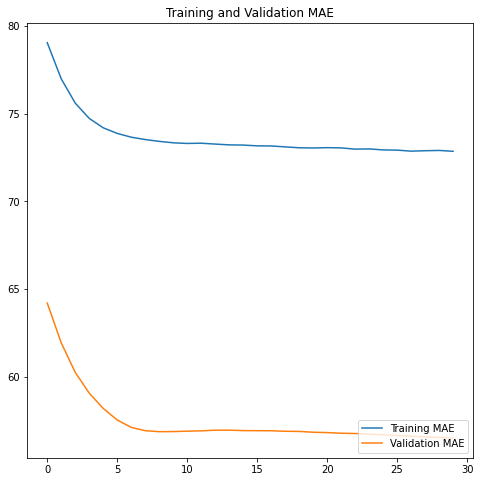

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### Finetune

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  956


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at= 800

# 동결 해제
for i, layer in enumerate(base_model.layers) :
    if i < fine_tune_at :
        layer.trainable = False
    else :
           if 'bn' in layer.name :
               layer.trainable = False

In [ ]:
model_filepath = '/content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

# transfer learning에서 최상의 weight을 불러옴.
model.load_weights(checkpoint_filepath)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10), # finetuning은 학습률을 낮게 설정.
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, None, None, 3)     0         
                                                                 
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
history_fine = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 75.5649 - mae: 75.5649
Epoch 1: val_mae improved from inf to 49.43916, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 67s 313ms/step - loss: 75.5649 - mae: 75.5649 - val_loss: 49.4392 - val_mae: 49.4392
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 71.1457 - mae: 71.1457
Epoch 2: val_mae improved from 49.43916 to 44.77898, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 55s 345ms/step - loss: 71.1457 - mae: 71.1457 - val_loss: 44.7790 - val_mae: 44.7790
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 69.9551 - mae: 69.9551
Epoch 3: val_mae improved from 44.77898 to 43.17474, saving model to /content/drive/MyDrive/AI_proj/effiv2L_finetuned_best_model.h5
159/159 [==============================] - 58s 366ms/step - loss: 69.9551 

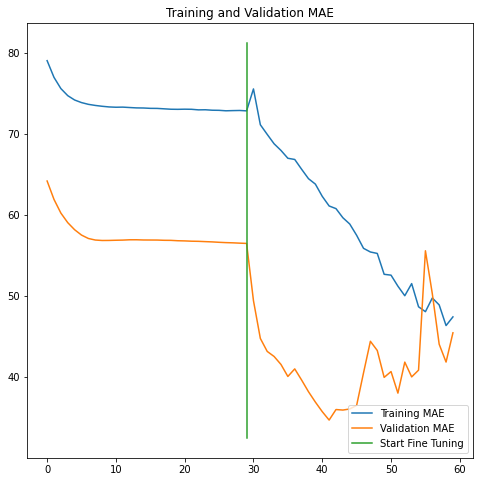

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae']+history_fine.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae']+history_fine.history['val_mae'], label='Validation MAE')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')
plt.show()

### prediction

In [ ]:
eff_model = tf.keras.models.load_model(model_filepath)

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_proj/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('/content/drive/MyDrive/AI_proj/data/effecientnetV2L_cnn.csv', index=False)